 # **ITCS 5356 Final Project Report**

### Loading the Dataset

In [2]:
import pickle
with open("ECG5000_train.pickle", "rb") as f:
    train_data = pickle.load(f)

with open("ECG5000_validation.pickle", "rb") as f:
    val_data = pickle.load(f)

ECGdataset = {
    "train": train_data,
    "val": val_data
}

print("First sample:\n", ECGdataset["train"][0])

tenth_sample = ECGdataset["train"][9]
first_feature = tenth_sample[1]
print("First feature of the 10th sample:", first_feature)

First sample:
 [ 0.         -0.11252183 -2.8272038  -3.7738969  -4.3497511  -4.376041
 -3.4749863  -2.1814082  -1.8182865  -1.2505219  -0.47749208 -0.36380791
 -0.49195659 -0.42185509 -0.30920086 -0.4959387  -0.34211867 -0.35533627
 -0.36791303 -0.31650279 -0.41237405 -0.47167181 -0.41345783 -0.36461703
 -0.44929829 -0.47141866 -0.42477658 -0.46251673 -0.55247236 -0.47537519
 -0.6942     -0.7018681  -0.59381178 -0.66068415 -0.71383066 -0.76980688
 -0.67228161 -0.65367605 -0.63940562 -0.55930228 -0.59167032 -0.49322332
 -0.46305183 -0.30164382 -0.23273401 -0.12505488 -0.15394314 -0.0243574
 -0.06560876  0.03499926  0.06193522  0.07119542  0.12392505  0.10312371
  0.22522849  0.12868305  0.30248315  0.25727621  0.19635161  0.17938297
  0.24472863  0.34121687  0.32820441  0.40604169  0.44660507  0.42406823
  0.48151204  0.4778438   0.62408259  0.57458456  0.59801319  0.5645919
  0.607979    0.62063457  0.65625291  0.68474806  0.69427284  0.66558377
  0.57579577  0.63813479  0.61491695  0.

### Pre-processing the Dataset

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def normalize_samples(data):
    """
    Normalize each sample (row) individually across the time dimension,
    excluding the first value (label).
    """
    normalized_data = []

    for sample in data:
        label = sample[0]
        features = sample[1:].reshape(-1, 1)
        scaler = StandardScaler()
        norm_features = scaler.fit_transform(features).flatten()
        normalized_sample = np.concatenate([[label], norm_features])
        normalized_data.append(normalized_sample)

    return np.array(normalized_data)

In [4]:
ECGdataset["train"] = normalize_samples(ECGdataset["train"])
ECGdataset["val"] = normalize_samples(ECGdataset["val"])

## **Method A**

### Implementng the Random Forest and SVM Model

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming `normalize_samples()` function is implemented for preprocessing
# Preprocess data
X_train = normalize_samples(ECGdataset["train"])[:, 1:]
Y_train = ECGdataset["train"][:, 0]
X_val = normalize_samples(ECGdataset["val"])[:, 1:]
Y_val = ECGdataset["val"][:, 0]

# Train-test split (if not already split)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)

# SVM Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, Y_train)
svm_pred = svm_model.predict(X_test)

# Evaluation
rf_accuracy = accuracy_score(Y_test, rf_pred)
svm_accuracy = accuracy_score(Y_test, svm_pred)

rf_cm = confusion_matrix(Y_test, rf_pred)
svm_cm = confusion_matrix(Y_test, svm_pred)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print("Random Forest Confusion Matrix:\n", rf_cm)
print("SVM Confusion Matrix:\n", svm_cm)


Random Forest Accuracy: 0.91
SVM Accuracy: 0.92
Random Forest Confusion Matrix:
 [[52  0  0  0]
 [ 0 36  0  2]
 [ 1  1  1  0]
 [ 2  3  0  2]]
SVM Confusion Matrix:
 [[51  1  0  0]
 [ 0 37  0  1]
 [ 1  0  2  0]
 [ 2  3  0  2]]


### Visualizing the Models

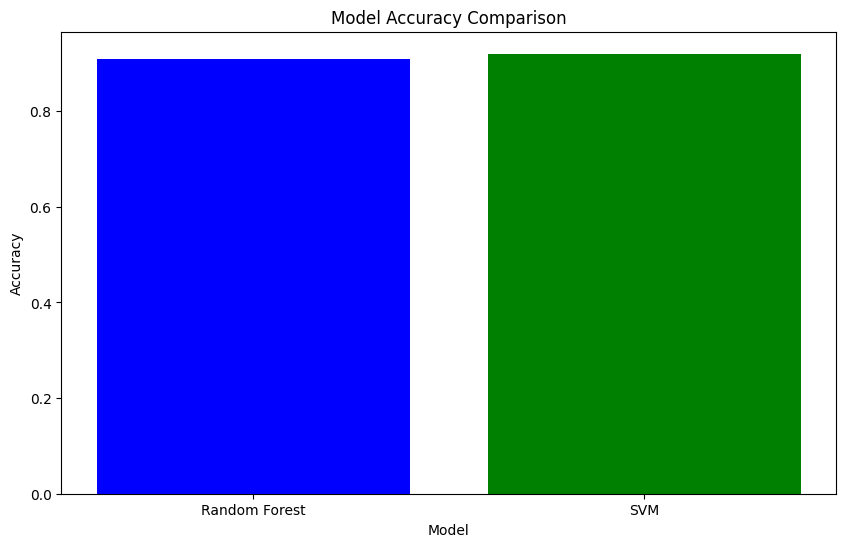

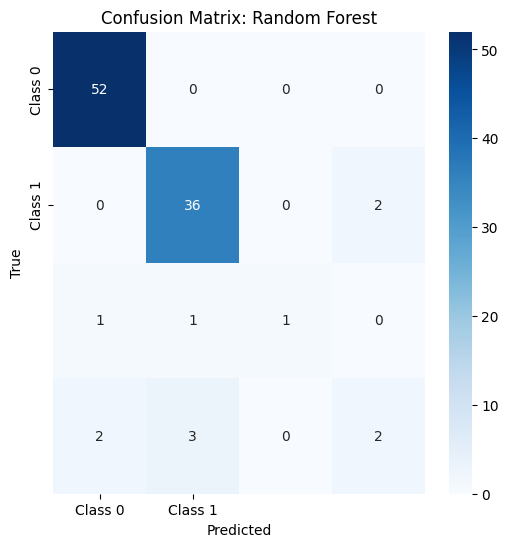

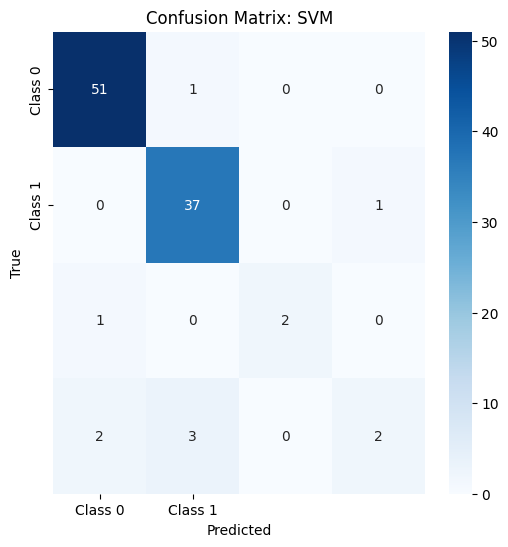

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualization 1: Plotting accuracy of the Random Forest and SVM
methods = ['Random Forest', 'SVM']
accuracies = [rf_accuracy, svm_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Visualization 2: Confusion Matrix for Random Forest
plt.figure(figsize=(6, 6))
rf_cm = confusion_matrix(Y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualization 3: Confusion Matrix for SVM
plt.figure(figsize=(6, 6))
svm_cm = confusion_matrix(Y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## **Method B**

### Implementing the CNN Model

In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

def preprocess_ecg_to_image(ecg_signal):
    plt.figure()
    plt.plot(ecg_signal)
    plt.axis('off')  # Hide axes
    plt.savefig('ecg_image.png', bbox_inches='tight', pad_inches=0)
    image = plt.imread('ecg_image.png')
    return image

X_train_images = np.array([preprocess_ecg_to_image(signal) for signal in ECGdataset["train"][:, 1:]])
X_val_images = np.array([preprocess_ecg_to_image(signal) for signal in ECGdataset["val"][:, 1:]])

# Normalize image data
X_train_images = X_train_images / 255.0
X_val_images = X_val_images / 255.0

# Labels
Y_train = ECGdataset["train"][:, 0]
Y_val = ECGdataset["val"][:, 0]

def cnn_model(input_shape):
    model = models.Sequential([
        # First Convolutional Layer: 16 filters, 3x3 kernel
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),  # Max-pooling to downsample

        # Second Convolutional Layer: 32 filters, 3x3 kernel
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),  # Max-pooling to downsample

        # Flatten the 2D matrix to a 1D vector
        layers.Flatten(),

        # Fully connected layer with 64 neurons
        layers.Dense(64, activation='relu'),

        # Output layer: sigmoid for binary classification
        layers.Dense(1, activation='sigmoid')  # For binary classification (e.g., healthy vs. unhealthy)
    ])
    
    # Compile the model with Adam optimizer and binary cross-entropy loss
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Example input shape for 64x64 grayscale images
input_shape = (64, 64, 1)  # 64x64 image, 1 channel (grayscale)

# Build the model
model = cnn_model(input_shape)

# Summary of the model architecture
model.summary()


/var/folders/z4/_r5f3_qs6rj8mh6wxmn47f7r0000gn/T/ipykernel_52527/1463532853.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


### Training the Model

In [8]:
history = model.fit(X_train_images, Y_train, epochs=10, batch_size=16, validation_data=(X_val_images, Y_val))

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val_images, Y_val)
print(f"Validation Accuracy: {val_accuracy}")

NameError: name 'X_train_images' is not defined